In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline
plt.style.use('seaborn-whitegrid')

import warnings
warnings.simplefilter('ignore')

%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('ab_test_ensembles.csv')
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [4]:
required_n = int(ceil(sms.NormalIndPower().solve_power(sms.proportion_effectsize(0.13, 0.15), power=0.8, alpha=0.05, ratio=1)))
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


In [5]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state=42)
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,bcf8452b-3056-4d45-994f-5f286fd9869a,2022-05-18 04:44:18.590293,control,standard,0,United Kingdom,42-49,new_user
1,3c827a98-0868-4ce5-ac31-8195e243af37,2022-05-14 05:22:43.771772,control,standard,0,United Kingdom,50-57,new_user
2,71c72bb9-13d9-4755-b398-b2c5d8b1c4d6,2022-05-23 08:52:53.050325,control,standard,0,United Kingdom,34-41,new_user
3,654ee878-b0c5-4223-b9fb-995ca3d2eaf1,2022-05-07 23:27:09.109877,control,standard,0,United Kingdom,26-33,registered_user
4,1e044366-7e86-4d92-bba7-3afaa6f887f8,2022-05-20 14:26:10.133979,control,standard,0,United Kingdom,42-49,new_user


## Часть 1
Вопрос: Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22?  

In [6]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


Отсюда убеждаемся, что контрольная группа в основном видит standart работу сервиса, а экспериментальная - svm_ensemble_v_1_22. 

In [7]:
duplicate_users = df['user_id'].value_counts(ascending=False)[df['user_id'].value_counts(ascending=False) > 1].count()
df = df[~df['user_id'].isin(df['user_id'].value_counts(ascending=False)[df['user_id'].value_counts(ascending=False) > 1].index)]
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке. Количество пользователей без дубликтов {df.shape[0]}.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке. Количество пользователей без дубликтов 294478.


In [8]:
# Стандартное отклонение 
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка 
se_proportion = lambda x: stats.sem(x, ddof=0)

Посмотрим на вероятность конверции для двух групп (и соответвенно двух типов работы сервиса): 

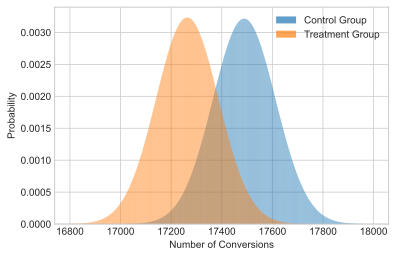

In [44]:
from scipy.stats import binom 

num_control = pd.crosstab(df['group'], df['variants']).iloc[0]['standard']
num_treatment = pd.crosstab(df['group'], df['variants']).iloc[1]['svm_ensemble_v_1_22']
   
click_control = df['converted'].loc[(df['group'] == 'control') & (df['variants'] == 'standard')].sum()
click_treatment = df['converted'].loc[(df['group'] == 'treatment') & (df['variants'] == 'svm_ensemble_v_1_22')].sum()

rate_control = click_control / num_control
rate_treatment = click_treatment / num_treatment

clicks = np.arange(16800, 18000)

prob_control = binom(num_control, rate_control).pmf(clicks)
prob_treatment = binom(num_treatment, rate_treatment).pmf(clicks)
 
plt.bar(clicks, prob_control, label="Control Group", alpha=0.7)
plt.bar(clicks, prob_treatment, label="Treatment Group", alpha=0.7)
plt.legend()
plt.xlabel("Number of Conversions")
plt.ylabel("Probability");


In [28]:
conversion_rates = ab_df.groupby('group')['converted'].agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates


,CR mean,CR std,CR se
group,,,
control,0.132415,0.338942,0.004933
treatment,0.119915,0.324862,0.004729


Отсюда делаем вывод, что выборочные статистики экспериментов отличаются. Посмотрим на графике на выборочные средние: 

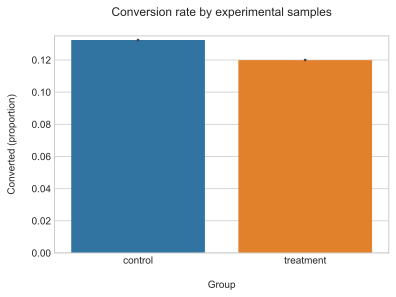

In [29]:
sns.barplot(x=ab_df['group'], y=ab_df['converted'], ci=False);
plt.ylim(0, 0.135);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [30]:
control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.83
p-value: 0.067
CI 95% for control group: [0.123, 0.142]
CI 95% for treatment group: [0.111, 0.129]


### Вывод. 
Полученное p-value больше выбранного альфа (0.067 > 0.05), то есть мы не можем отклонить нулевую гипотезу. Отсюда следует, что нам нужно оставить старый вариант работы сервера.   
Кроме этого, доверительные интервалы для обеих групп не достигают 15%. Можно сделать вывод, что конверсия нового варианта работы сервера будет ближе к стандартному варианту, чем к определенному в начале 15%. 

## Часть 2
Вопрос: Стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы?

In [31]:
df_registered = df[(df['user_type'] == 'registered_user')]
df_new = df[(df['user_type'] == 'new_user')]

In [32]:
control_sample_registered = df_registered[df_registered['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample_registered = df_registered[df_registered['group'] == 'treatment'].sample(n = required_n, random_state=42)
ab_df_registered = pd.concat([control_sample_registered, treatment_sample_registered], axis=0)
ab_df_registered.reset_index(drop=True, inplace=True)

control_sample_new = df_new[df_new['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample_new = df_new[df_new['group'] == 'treatment'].sample(n = required_n, random_state=42)
ab_df_new = pd.concat([control_sample_new, treatment_sample_new], axis=0)
ab_df_new.reset_index(drop=True, inplace=True)



In [33]:
pd.concat([pd.crosstab(df_registered['group'], df_registered['variants']),pd.crosstab(df_new['group'], df_new['variants'])], axis=0)


variants,standard,svm_ensemble_v_1_22
group,,
control,72483,969
treatment,959,72829
control,72791,959
treatment,1006,72482


Отсюда убеждаемся, что контрольная группа для новых и зарегистрированных пользователей в основном видит standart работу сервиса, а экспериментальная - svm_ensemble_v_1_22. 

Посмотрим на вероятность конверции для двух групп (и соответвенно двух типов работы сервиса) для зарегистрированных и новых пользователей: 

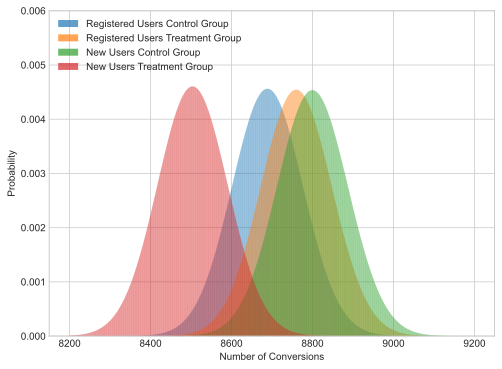

In [43]:
num_control_reg = pd.crosstab(df_registered['group'], df_registered['variants']).iloc[0]['standard']
num_treatment_reg = pd.crosstab(df_registered['group'], df_registered['variants']).iloc[1]['svm_ensemble_v_1_22']
num_control_new = pd.crosstab(df_new['group'], df_new['variants']).iloc[0]['standard']
num_treatment_new = pd.crosstab(df_new['group'], df_new['variants']).iloc[1]['svm_ensemble_v_1_22']

click_control_reg = df_registered['converted'].loc[(df_registered['group'] == 'control') & (df_registered['variants'] == 'standard')].sum()
click_treatment_reg = df_registered['converted'].loc[(df_registered['group'] == 'treatment') & (df_registered['variants'] == 'svm_ensemble_v_1_22')].sum()
click_control_new = df_new['converted'].loc[(df_new['group'] == 'control') & (df_new['variants'] == 'standard')].sum()
click_treatment_new = df_new['converted'].loc[(df_new['group'] == 'treatment') & (df_new['variants'] == 'svm_ensemble_v_1_22')].sum()

rate_control_reg = click_control_reg / num_control_reg
rate_treatment_reg = click_treatment_reg / num_treatment_reg
rate_control_new = click_control_new / num_control_new
rate_treatment_new = click_treatment_new / num_treatment_new

clicks = np.arange(8200, 9200)

prob_control_reg = binom(num_control_reg, rate_control_reg).pmf(clicks)
prob_treatment_reg = binom(num_treatment_reg, rate_treatment_reg).pmf(clicks)
prob_control_new = binom(num_control_new, rate_control_new).pmf(clicks)
prob_treatment_new = binom(num_treatment_new, rate_treatment_new).pmf(clicks)
 
plt.figure(figsize=(8,6))    
plt.bar(clicks, prob_control_reg, label="Registered Users Control Group", alpha=0.7)
plt.bar(clicks, prob_treatment_reg, label="Registered Users Treatment Group", alpha=0.7)
plt.bar(clicks, prob_control_new, label="New Users Control Group", alpha=0.7)
plt.bar(clicks, prob_treatment_new, label="New Users Treatment Group", alpha=0.7)
plt.legend(loc=2)
plt.ylim(0, 0.006);
plt.xlabel("Number of Conversions")
plt.ylabel("Probability");

Анализ для зарегистрированных пользователей:

In [45]:
conversion_rates_registered = ab_df_registered.groupby('group')['converted'].agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_registered


,CR mean,CR std,CR se
group,,,
control,0.121398,0.326590,0.004754
treatment,0.119280,0.324117,0.004718


Отсюда делаем вывод, что выборочные статистики экспериментов для зарегистрированных пользователей практически одинаковы. Отличаются выборочные средние. Посмотрим на графике:

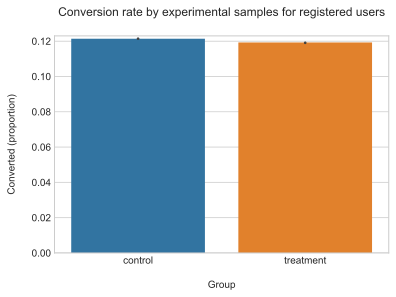

In [46]:
sns.barplot(x=ab_df_registered['group'], y=ab_df_registered['converted'], ci=False);
plt.ylim(0, 0.123);
plt.title('Conversion rate by experimental samples for registered users', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

Анализ для новых пользователей:

In [47]:
conversion_rates_new = ab_df_new.groupby('group')['converted'].agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_new


,CR mean,CR std,CR se
group,,,
control,0.122034,0.327325,0.004764
treatment,0.127331,0.333343,0.004852


Отсюда делаем вывод, что выборочные статистики экспериментов для новых пользователей практически одинаковы. В том числе и выборочные средние.

In [48]:
control_results_registered = ab_df_registered[ab_df_registered['group'] == 'control']['converted']
treatment_results_registered = ab_df_registered[ab_df_registered['group'] == 'treatment']['converted']
control_results_new = ab_df_new[ab_df_new['group'] == 'control']['converted']
treatment_results_new = ab_df_new[ab_df_new['group'] == 'treatment']['converted']

n_con_registered = control_results_registered.count()
n_treat_registered = treatment_results_registered.count()
successes_registered = [control_results_registered.sum(), treatment_results_registered.sum()]
nobs_registered = [n_con_registered, n_treat_registered]

n_con_new = control_results_new.count()
n_treat_new = treatment_results_new.count()
successes_new = [control_results_new.sum(), treatment_results_new.sum()]
nobs_new = [n_con_new, n_treat_new]

z_stat_registered, pval_registered = proportions_ztest(successes_registered, nobs=nobs_registered)
(lower_con_registered, lower_treat_registered), (upper_con_registered, upper_treat_registered) = proportion_confint(successes_registered, nobs=nobs_registered, alpha=0.05)

z_stat_new, pval_new = proportions_ztest(successes_new, nobs=nobs_new)
(lower_con_new, lower_treat_new), (upper_con_new, upper_treat_new) = proportion_confint(successes_new, nobs=nobs_new, alpha=0.05)


print(f'Z-statistic for registered users: {z_stat_registered:.2f}. Z-statistic for new users: {z_stat_new:.2f}.')
print(f'p-value for registered users: {pval_registered:.3f}. p-value for new users: {pval_new:.3f}')
print(f'CI 95% for control group (registered users): [{lower_con_registered:.3f}, {upper_con_registered:.3f}]')
print(f'CI 95% for control group (new users): [{lower_con_new:.3f}, {upper_con_new:.3f}]')
print(f'CI 95% for treatment group (registered users): [{lower_treat_registered:.3f}, {upper_treat_registered:.3f}]')
print(f'CI 95% for treatment group (new users): [{lower_treat_new:.3f}, {upper_treat_new:.3f}]')


Z-statistic for registered users: 0.32. Z-statistic for new users: -0.78.
p-value for registered users: 0.752. p-value for new users: 0.436
CI 95% for control group (registered users): [0.112, 0.131]
CI 95% for control group (new users): [0.113, 0.131]
CI 95% for treatment group (registered users): [0.110, 0.129]
CI 95% for treatment group (new users): [0.118, 0.137]


### Вывод. 
Полученное p-value больше выбранного альфа, как для зарегистрированных пользователей, так и для новых (0.752 > 0.05 и 0.436 > 0.05 соответственно), то есть мы не можем отклонить нулевую гипотезу. Отсюда следует, что нам нужно оставить старый вариант работы сервера.   
Кроме этого, доверительные интервалы для обеих групп не достигают 15%,  как для зарегистрированных пользователей, так и для новых. Можно сделать вывод, что конверсия нового варианта работы сервера будет ближе к стандартному варианту, чем к определенному в начале 15%. 